In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 99999

import warnings
warnings.filterwarnings("ignore")

def readdata_MT5_Date(market,tf,path,start,stop):
    
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd
    
    while True:

        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        mk=str(market)
        TF="mt5.TIMEFRAME_"+str(tf)

        start_y , start_m , start_d = start.split("-")
        stop_y , stop_m , stop_d = stop.split("-")
        
        utc_from = datetime(int(start_y), int(start_m), int(start_d))
        utc_to = datetime(int(stop_y), int(stop_m), int(stop_d))
        
        rates = mt5.copy_rates_range(mk, eval(TF), utc_from, utc_to) 
    

        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        #rates_frame=rates_frame[(rates_frame.T != 0).any()]
        if rates_frame is not None:
            return rates_frame
            break

def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
    
    cnt=0
    salta=0
    while True:
        cnt=cnt+1
        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            if cnt<2:
                continue
            else:
                salta=1
                break
    if salta == 0:
        rates_frame = pd.DataFrame(rates)
        rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
        rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
        rates_frame.columns=(["time","open","high","low","close","volume"])
        rates_frame=rates_frame.set_index(["time"])
        rates_frame=rates_frame[(rates_frame.T != 0).any()]
        return rates_frame
    else:
        return pd.DataFrame()
    
def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return tmp

def ordine_market(mercato,quantita,deviazione,path,direzione,commento):
    import time
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    
    mta.initialize(path)
    status=0
    if direzione == "long":
    
        order = Order.as_buy(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    
    if direzione == "short":
    
        order = Order.as_sell(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    while True: 
        r = order.send()
        time.sleep(1)
        if r[7]=='Request executed':
            print(r,'Request executed')
            status=1
            break
        if r[7]=="Market closed":
            print(r[7],"Market closed")
            status=0
            break
    return status

def check_start_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[0]]
    z=list(set(z))
    z.sort()
    return y[0],z[0]

def check_end_sessiona(path,simbolo):
    x=readdata(simbolo,"M1",3000,path)
    y=list(set(x.index.hour))
    y.sort()
    z=x.index.minute[x.index.hour==y[-1]]
    z=list(set(z))
    z.sort()
    return y[-1],z[-1]

def get_spread(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    try:
        if len(symbol_info)>0:
            return symbol_info.spread
    except:
        return None
    
def get_category(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['path']

def get_ETF(path,simb):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    return symbol_info_dict['description']
    
    
def get_min_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_min

def get_max_contract(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.volume_max

def remove_outlier(y):
    Q1 = np.percentile(y, 10, #25
                       interpolation = 'midpoint')
    Q3 = np.percentile(y, 90, #75
                       interpolation = 'midpoint')
    IQR = Q3 - Q1
    y[y>=Q3+1.5*IQR]=0
    y[y<=Q1-1.5*IQR]=0
    return y

def serialize_kmeans_model(kmeans_model):
    
    model_data = {
        'n_clusters': kmeans_model.n_clusters,
        'cluster_centers_': kmeans_model.cluster_centers_.tolist(),
        'labels_': kmeans_model.labels_.tolist(),
        'inertia_': kmeans_model.inertia_,
        'init': kmeans_model.init,
        'n_init': kmeans_model.n_init,
        'max_iter': kmeans_model.max_iter,
        'tol': kmeans_model.tol,
        'algorithm': kmeans_model.algorithm,
        'random_state': kmeans_model.random_state,
        'n_threads' : kmeans_model._n_threads
    }
    return model_data

def recreated_kmeans_model(serialized_kmeans):
    
    from sklearn.cluster import KMeans
    
    kmeans_recreated = KMeans(n_clusters=serialized_kmeans['n_clusters'],
                           init=serialized_kmeans['init'],
                           n_init=serialized_kmeans['n_init'],
                           max_iter=serialized_kmeans['max_iter'],
                           tol=serialized_kmeans['tol'],
                           algorithm=serialized_kmeans['algorithm'],
                           random_state=serialized_kmeans['random_state'])

    kmeans_recreated.cluster_centers_ = serialized_kmeans['cluster_centers_']
    kmeans_recreated.labels_ = serialized_kmeans['labels_']
    kmeans_recreated.inertia_ = serialized_kmeans['inertia_']
    kmeans_recreated._n_threads = serialized_kmeans['n_threads']

    return kmeans_recreated

def get_swap(path,simbolo):
    import MetaTrader5 as mt5

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    symbol_info=mt5.symbol_info(simbolo)
    return symbol_info.swap_long , symbol_info.swap_short


def get_all_ETF_symbols(path):
    
    all_symbols = allsymbols(path)
    
    ls_temp=[]
    
    for simb in all_symbols:
    
        import MetaTrader5 as mt5
        if not mt5.initialize(path):
            print("initialize() failed, error code =",mt5.last_error())
            quit()
        symbol_info=mt5.symbol_info(simb)
        if symbol_info!=None:
            symbol_info_dict = mt5.symbol_info(simb)._asdict()
        mt5.shutdown()    

        if "ETF" in symbol_info_dict['description']:
            ls_temp.append(simb)
    return ls_temp

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8, 8)  
plt.rcParams['lines.linewidth'] = .5

In [3]:
from numba import jit
@jit(nopython=True)
def engine_MP(pct , pct_total , ptn_body , ptn_range , np_data, direzione ,lookback):
    
    conta=0
    mp=np.zeros_like(np_data[0])

    for i in (range(len(np_data[0]))):
        if i >lookback:
            op=np_data[0,i-lookback:i] 
            hi=np_data[1,i-lookback:i]
            lo=np_data[2,i-lookback:i]
            cl=np_data[3,i-lookback:i]
        
            a=cl-op
            body=(a - np.min(a))/np.ptp(a)  
            
            a=hi-lo
            range_=(a - np.min(a))/np.ptp(a)
        
            diff_1=body-ptn_body
            diff_2=range_-ptn_range
            diff_1=np.where((diff_1<pct)&(diff_1>-pct),1,diff_1)
            diff_1=np.where(diff_1!=1,0,diff_1)
            diff_2=np.where((diff_2<pct)&(diff_2>-pct),1,diff_2)
            diff_2=np.where(diff_2!=1,0,diff_2)
            
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="buy"):
                mp[i] = 1
            if (my_sum(diff_1)>=pct_total)&(my_sum(diff_2)>=pct_total)&(direzione=="sell"):
                mp[i] = 1
    return mp
    
@jit(nopython=True)
def my_sum(d):
    total = 0.0
    for valore in d:
        total += valore
    return total
    
def to_live(THRESHOLD_VALUE , THRESHOLD_PATTERN, data,  pattern_detect):
    
        np_data = data.T.values
        ptn_body =  pattern_detect[0]
        ptn_range = pattern_detect[1]
        direzione = pattern_detect[2][0]
        lookback = pattern_detect[2][2]
        #n_days = pattern_detect[2][1]
        
        pct=round(1-float((1/100)*THRESHOLD_VALUE),2)
        pct_total=int((lookback/100)*THRESHOLD_PATTERN)


        signal = engine_MP(pct,pct_total,ptn_body,ptn_range,np_data,direzione,lookback)

        return signal


@jit(nopython=True)
def propagate_ones(arr, steps):
    result = np.zeros_like(arr)  # Crea un array di zeri con la stessa forma di arr
    ones_indices = np.where(arr == 1)[0]  # Trova gli indici dei valori 1 in arr

    for idx in ones_indices:
        result[idx] = 1  # Imposta il valore 1 nella posizione corrente

        # Propaga il valore 1 in avanti per X passi
        for step in range(1, steps + 1):
            if idx + step < len(arr):
                result[idx + step] = 1
            else:
                break  # Esci se raggiungi la fine dell'array

    return result

@jit(nopython=True)
def TP_SL(tradelist,TP,SL):
    
    a=tradelist.copy()
    if (TP!=0)|(SL!=0):            

        if TP == 0 :
            TP = np.inf
        if SL == 0:
            SL = np.inf

        b = a.copy()
        cnt = 1
        for e in range(len(a)):
            if a[e]!=0:
                a[e]=cnt
            if (a[e]==0)&(a[e-1]!=0):
                cnt=cnt+1
        
        for cnt_value in range(1, int(max(a)) + 1):
            mask = np.where(a == cnt_value)[0]
            z = np.cumsum(b[mask])
            tp_idx =  np.where(z > TP)[0]
            sl_idx = np.where(z < -SL)[0]

            if len(tp_idx) > 0 or len(sl_idx) > 0:
                first = min(np.inf if len(tp_idx) == 0 else tp_idx[0]+1, np.inf if len(sl_idx) == 0 else sl_idx[0]+1)
                q = b[mask]
                q[first:] = 0
                b[mask] = q
    
        return b
    else:
        return a
        
def sharpe_ratio(operations):
    
    equity = np.cumsum(operations)
    netprofit = equity[-1]
    std = np.std(equity)
    if std != 0:
        return round(netprofit / std,2)
    else:
        return -99999

def drawdown_max(operations):

    equity_cumulata = np.cumsum(operations)
    maxvalue = np.maximum.accumulate(equity_cumulata)
    drawdown = equity_cumulata - maxvalue
    return min(drawdown)

function_set=('neg', 'inv' ,'add', 'mul', 'sqrt', 'log', 'cos', 'sin','sub', 'div', 'min', 'max', 'abs', 'tan')

def resample_standard_session(original_tf,resample_tf,dataset):
    
    original_tf=int(original_tf.replace("Min",""))
    resample_tf=int(resample_tf.replace("Min",""))
    df_0=dataset.copy()
    
    df_0.index=df_0.index - pd.DateOffset(minutes=original_tf)
    df_resample=df_0.resample(str(resample_tf)+'Min').agg({'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last','volume':'sum'})
    
    if resample_tf == 1440 :
        df_resample = df_resample
    else:
        df_resample.index=df_resample.index + pd.DateOffset(minutes=resample_tf)
        
    df_resample=df_resample.dropna()
    return df_resample

def check_history_name(file_name,dir_history):
    import os
    storici = os.listdir(dir_history)
    for e in storici:
        x=e.split("_")[0]
        x=x.replace("@","")
        if x == file_name:
            file_name=e
            break
    return file_name


def bk_models(df,selected_hours):

    newdf = df[["pred","Total_return"]].copy()
    newdf = newdf.fillna(0)
    
    idx = newdf.index
    a=newdf.pred.shift(1 , fill_value=0)
    
    if len(selected_hours)!=0:
        a[~a.index.hour.isin(selected_hours)]=0
    
    b = newdf.Total_return.values
    b=b*a
    
    a[a==-1]=1
    a=a.astype(int)
    a=a.values
    cnt = 0
    for e in range(len(a)):
        try:
            if (a[e]==0)&(a[e+1]!=0):
                cnt=cnt+1
        except:
               cnt=cnt+1 
        if a[e]!=0:
            a[e]=cnt
            
    trade_list=[]
    for cnt_value in range(1, int(max(a)) + 1):
        mask =np.where(a==cnt_value)[0] 
        z = b[mask]
        tmp_index = np.where(a == cnt_value)[0]
        if len(tmp_index)>0:
            try:
                trade_list.append([round(np.sum(z),2),idx[tmp_index][0],idx[tmp_index+1][-1]])
            except:
                trade_list.append([round(np.sum(z),2),idx[tmp_index][0],idx[tmp_index][-1]])
    
    
    tradelist = pd.DataFrame(trade_list)
    tradelist.columns=(["operations","entry_time","exit_time"])
    tradelist.set_index(["entry_time"],inplace=True)
    tradelist.index = pd.to_datetime(tradelist.index)
    tradelist["time_in_trade"] = tradelist.exit_time - tradelist.index
    tradelist = tradelist[tradelist.operations!=0]
    return tradelist


In [4]:
import joblib
import os

os.chdir(r"C:\Users\Drako\GPlearn\DB")
files = os.listdir(r"C:\Users\Drako\GPlearn\DB")
files

['CL_GP_360Min_307bbe7c-6bf7-11ee-8b39-50e085baac0b.joblib',
 'CL_GP_360Min_4585a015-6bf6-11ee-ab6e-50e085baac0b.joblib',
 'CL_GP_360Min_d2712eda-6bf6-11ee-a57f-50e085baac0b.joblib',
 'CL_GP_360Min_dd55a074-6bf9-11ee-b29d-50e085baac0b.joblib',
 'C_GP_240Min_7372b78d-6bfb-11ee-a4eb-50e085baac0b.joblib',
 'C_GP_240Min_7bedebe3-6bfb-11ee-bfec-50e085baac0b.joblib',
 'C_GP_240Min_8e00fe74-6bfb-11ee-9af5-50e085baac0b.joblib',
 'HO_GP_240Min_2cc38050-6c21-11ee-ab51-50e085baac0b.joblib',
 'HO_GP_240Min_afce9c24-6c1e-11ee-85e9-50e085baac0b.joblib',
 'HO_GP_240Min_f6b39a7d-6c20-11ee-a34b-50e085baac0b.joblib',
 'HO_GP_60Min_3520f961-6c25-11ee-93cc-50e085baac0b.joblib',
 'HO_GP_60Min_f1ddb5a4-6c26-11ee-b326-50e085baac0b.joblib',
 'LC_GP_60Min_3042ab6e-6cc6-11ee-b06e-50e085baac0b.joblib',
 'LC_GP_60Min_47e005bb-6ce0-11ee-8b48-50e085baac0b.joblib',
 'LC_GP_60Min_922466e0-6cca-11ee-b0de-50e085baac0b.joblib',
 'LC_GP_60Min_f3f96606-6cd7-11ee-8ce2-50e085baac0b.joblib',
 'W_GP_240Min_1cd74aca-6c37-11ee-

In [5]:
os.chdir(r"C:\Users\Drako\GPlearn\DB")

loaded_data = joblib.load('LC_GP_60Min_47e005bb-6ce0-11ee-8b48-50e085baac0b.joblib')
pattern_detect , THRESHOLD_VALUE , THRESHOLD_PATTERN = loaded_data['numpy_array']
info = loaded_data['test_file_path']
est_gp = loaded_data['model']

info 

['LC', 400, 'Etc/GMT0', '60Min', [], 'long']

In [6]:
dir_history = (r"C:\Users\Drako\TS_API\15102023")

BIGPOINTVALUE = int(info[1])

SIMBOLO = info[0]

selected_hours = info[4]

os.chdir(dir_history)
file_name  =  check_history_name(SIMBOLO,dir_history)
dataset = pd.read_csv(file_name, index_col="date_time" , parse_dates=["date_time"])

dataset.index=dataset.index.tz_localize("UTC").tz_convert(info[2])
dataset.index=dataset.index.tz_localize(None)

dataset = resample_standard_session("60Min",info[3],dataset)

dataset = dataset.loc["2010-01-01":]

dataset["PNL"] = (dataset["open"].shift(-1)-dataset["open"])*BIGPOINTVALUE
dataset["PNL"] = dataset["PNL"].fillna(0)
#dataset["PNL"] = remove_outlier(dataset["PNL"])
if len(info[4])!=0:
    dataset["PNL"][~dataset["PNL"].index.hour.isin(selected_hours)]=np.nan
dataset["PNL"] = dataset["PNL"].fillna(0)

from tqdm.notebook import tqdm

X0 = pd.DataFrame(index=dataset.index)
cnt=0
for I in tqdm(range(len(pattern_detect))):
    exit = pattern_detect[I][2][1]
    signal = to_live(THRESHOLD_VALUE , THRESHOLD_PATTERN, dataset,  pattern_detect[I]) 
    X0["ptn_"+str(cnt)] = signal
    cnt=cnt+1

  0%|          | 0/56 [00:00<?, ?it/s]

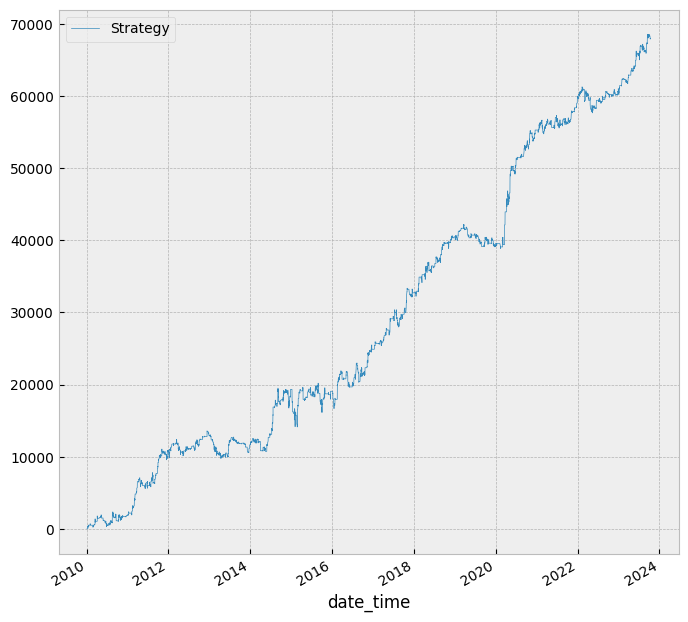

In [7]:
TP , SL , costi = 0 , 0 , 0

pred = est_gp._program.execute(X0.values)
pred=np.where(pred>0,1,pred)
pred=np.where(pred!=1,0,pred)
pred = propagate_ones(pred, exit-1)

df = dataset.PNL.to_frame("Total_return")
if info[5] == "short":
    df=-df
df["pred"]=pred
df["Strategy"]=df.Total_return*df.pred.shift(1)
df["Strategy"] = df["Strategy"].fillna(0)
                                      
tmp_costi = TP_SL(df["Strategy"].to_numpy() ,TP,SL)

df["Strategy_NO_Costs"] = tmp_costi
df["Strategy_TP_SL"] =  np.where((tmp_costi!=0)&(np.roll(tmp_costi,1)==0),tmp_costi-costi,tmp_costi)
df[["Strategy"]].cumsum().plot()

tradelist = bk_models(df,selected_hours)

In [8]:
tradelist.tail()

,operations,exit_time,time_in_trade
entry_time,,,
2023-09-20 18:00:00,-410.0,2023-09-21 17:00:00,0 days 23:00:00
2023-09-22 14:00:00,500.0,2023-09-22 17:00:00,0 days 03:00:00
2023-10-04 18:00:00,-140.0,2023-10-05 16:00:00,0 days 22:00:00
2023-10-06 18:00:00,-390.0,2023-10-09 16:00:00,2 days 22:00:00
2023-10-09 17:00:00,-60.0,2023-10-10 17:00:00,1 days 00:00:00


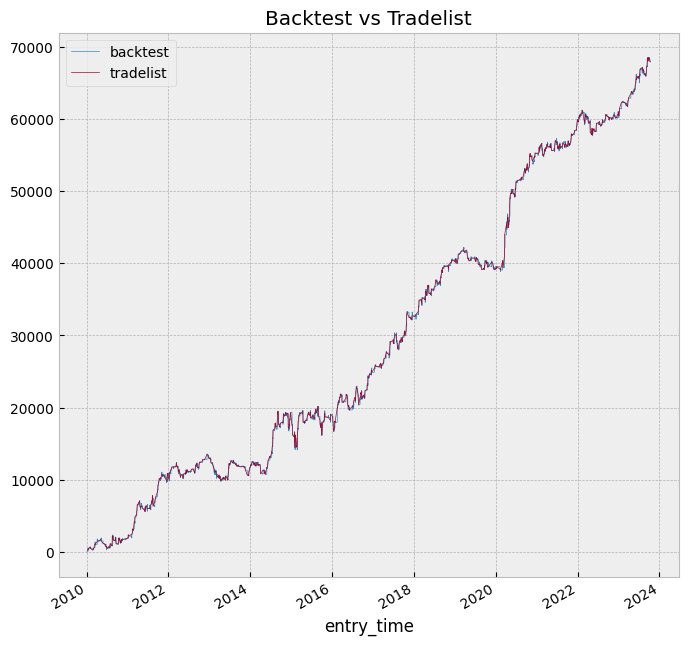

In [10]:
df.Strategy.cumsum().plot(title = "Backtest vs Tradelist" , label="backtest")
tradelist.operations.cumsum().plot(label="tradelist")
plt.legend()
plt.show()